# Reading Data into Panda Dataframes

In [1]:
%matplotlib inline
import pandas as pd
googData = pd.read_csv('GOOG_BIG.csv')
temp =  pd.to_datetime(googData['Date'])
googData['Date'] = temp
googData.set_index('Date', inplace=True, drop=True)
googData.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,98.062202,101.162041,97.098465,100.700043,100.700043,31894300
2005-01-04,100.049278,100.809334,96.114868,96.621567,96.621567,27690700
2005-01-05,96.099960,97.813812,95.493904,96.129768,96.129768,16580200
2005-01-06,96.909698,97.317047,93.253479,93.665794,93.665794,20909100
2005-01-07,94.704041,96.497375,93.780052,96.298668,96.298668,19451500


# Preprocessing Functions for Panda Dataframes

In [2]:
#computing rolling average of a frame over n days
def rollingAVG(data, n):
    return data.rolling(n).mean()

#compute moving average of a frame over n days
def movingAVG(data, n): 
    newData = timeLag(data,n)
    return pd.merge(data,newData.mean(axis=1).to_frame(), on='Date')

def timeLag(data, n):
    temp = data
    for i in range(1,n):
        temp2 = temp.shift(i).rename(columns={'Close': 'Close' + str(i)})
        data = pd.merge(data, temp2, on='Date')
    return data.iloc[n:] #removes NaN issues

def logScale(data, b): #TODO
    return

# Load, Preprocess, Train and Test

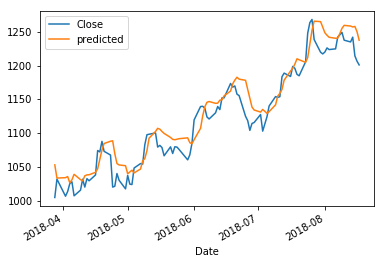

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

''' Load CSV File '''

googData = pd.read_csv('GOOG_BIG.csv')
temp =  pd.to_datetime(googData['Date'])
googData['Date'] = temp
googData.set_index('Date', inplace=True, drop=True)
googData.head()

''' Preprocessing '''

train = googData.loc[:,'Close'].to_frame()
train = timeLag(train, 8)

''' Train and Test'''

clf = MLPRegressor(hidden_layer_sizes=(200,))

X = train[train.columns.drop('Close')]
y = train['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X.values[:-100,:]
y_train = y.values[:-100]
clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print(score)
predictions = clf.predict(X)
plottable = train.loc[:,'Close'].to_frame()
visualizePrediction = pd.DataFrame(data = predictions, index=train.index, columns = ['predicted'])
plottable = pd.merge(plottable, visualizePrediction, on='Date')
plottable.iloc[-100:,].plot()

# Creating a Simulation 
#### Given a number of strategies, see how they perform on stock(s) over some specified period of time
---
### Basic Flow
1. Load requested stock information
2. Create strategies (i.e. each day, how much money do you invest/divest)
    * Dollar Cost Averaging
    * Machine learning informed trading (purchasing/selling stocks in proportion to expected value from time series forecasting while potentially considering error / confidence
3. Simulate using different strategies over the specified time period, display results
---
#### I tried to make this extensible so it will be easy to add to and quickly generate results



# Retrieve stock information
#### Room to add more data (highs, lows, volumes of trade, etc.)

In [4]:
def getClosePrices(stock, begin, end):
    dates = []
    opens = []
    highs = []
    lows = []
    closes = []
    adj_closes = []
    volumes = []
    path = "C:\\Users\\x92423\Documents\\Thesis Data Grab\\" + str(stock) + ".csv" 
    with open(path) as csvfile:
        data = csv.reader(csvfile, delimiter=',')
        next(data) #skip header row
        for row in data:
            date = datetime.datetime.strptime(row[0], "%Y-%m-%d").date()
            if (date >= begin and date <= end):
                dates.append(date)
                opens.append(float(row[1]))
                highs.append(float(row[2]))
                lows.append(float(row[3]))
                closes.append(float(row[4]))
                adj_closes.append(float(row[5]))
                volumes.append(int(row[6]))    
    return closes

# Create Strategies
#### Does the heavy lifting and machine learning

In [52]:
from statsmodels.tsa.arima_model import ARIMA
import csv
import sys
import time
import datetime
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

def invest(change, cash):
    return change*cash

'''
returns two data frames, a train and a test set.
train set is data up until time period,
test set is data during time period.
'''
def getData(stock, timePeriod):
    path = "C:\\Users\\x92423\Documents\\Thesis Data Grab\\" + str(stock) + ".csv" 
    series = pd.read_csv(path, parse_dates=[0], index_col=0)
    series = series.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])#test_set
    test_series = series[timePeriod[0]:timePeriod[1]]
    train_series = series[:timePeriod[0]]
    return  train_series, test_series

def createStrategy(strat, stocks, timePeriod, cash, days, stockList, options=[]):
    '''
    default values in case they are not specified in options
    '''
    interval = 5
    p = 1
    i = 0
    q = 1
    train_size = 0
    lag = 5
    verbose = False
    ansMap = {}
    for opt in options:
        if  'p=' in opt:
            p = int(opt[2:])
        elif 'q=' in opt:
            q = int(opt[2:])
        elif 'i=' in opt:
            i = int(opt[2:])
        elif 'interval=' in opt:
            interval = int(opt[9:])
        elif 'train_size=' in opt:
            train_size = int(opt[11:])
        elif 'lag=' in opt:
            lag = int(opt[4:])
        elif 'verbose' or 'v' in opt:
            verbose = True
    if strat == "DCA":
        for stock in stocks: 
            print("Strategy: Dollar-Cost Averaging with an interval of " + str(interval))
            numInvestments = math.floor(days/interval)
            tempList = []
            for i in range(numInvestments):
                tempList.append((i*interval, cash/numInvestments))
            if verbose:
                for day, amt in tempList:
                    print("Day " + str(day) +": $" + str(amt))
            ansMap[stock] = tempList
    elif (strat == "ARIMA"):
        for stock in stocks:
            print("Strategy: ARIMA("+str(p)+","+str(i)+","+str(q)+")")
            investments = []
            tempList = []
            train, test = getData(stock, timePeriod)
            if (train_size == 0):
                train = train.values
            else:
                train = train.values[-train_size:]
            test = test.values
            history = [x for x in train]
            predictions = list()
            for t in range(len(test)):
                if (t == 0):
                    print("ARIMA is slow. This will take " + str(len(test)) +" iterations. ARIMA is training on " + str(len(train)) + " days of stock data and testing on " + str(len(test)) + "days!")
                if verbose:
                    if (t%10 == 0):
                        print("iteration " + str(t))
                model = ARIMA(history, order=(p,i,q))
                model_fit = model.fit(disp=-1)
                output = model_fit.forecast()
                yhat = output[0]
                expectedChange = (yhat-history[-1])/history[-1]
                temp = invest(expectedChange, cash)
                tempList.append((t,temp[0]))
                predictions.append(yhat)
                obs = test[t]
                history.append(obs)
            total = 0
            for day, amt in tempList:# figure out sum
                total += amt
            for day, amt in tempList:#normalize investments based on principal
                investments.append((day, amt/total*cash))
            if verbose:
                for day, amt in investments:
                    print("Day " + str(day) +": $" + str(amt))

            #print(investments)
            ansMap[stock] = investments     
    elif (strat == "LINREG"):
        from sklearn.linear_model import LinearRegression
        for stock in stocks:
            train, test = getData(stock, timePeriod)
            holdTrain = train.values
            train = timeLag(train, lag)
            test = timeLag(test, lag)
            X_train, X_test = train[train.columns.drop('Close')], test[test.columns.drop('Close')]
            y_train, y_test = train['Close'], test['Close']
            lm = LinearRegression()
            lm.fit(X_train, y_train)
            predictY = lm.predict(X_test)
            tempList = []
            investments = []
            history = [x for x in holdTrain]
            for i in range(len(predictY)):
                expectedChange = (predictY[i]-history[-1])/history[-1]
                temp = invest(expectedChange, cash)
                tempList.append((i, float(temp)))
                history.append(y[i])
            total = 0
            for day, amt in tempList:# figure out sum
                total += amt
            for day, amt in tempList:#normalize investments based on principal
                investments.append((day, amt/total*cash))
            if verbose:
                for day, amt in investments:
                    print("Day " + str(day) +": $" + str(amt))
            ansMap[stock] = investments
    elif (strat == "NN"):
        for stock in stocks:
            train, test = getData(stock, timePeriod)
            train = timeLag(train, 8)
            test = timeLag(train, 8)
            clf = MLPRegressor(hidden_layer_sizes=(200,))
            X_train = train[train.columns.drop('Close')]
            y_train = train['Close']
            clf.fit(X_train, y_train)
            predictions = clf.predict(X)
            plottable = train.loc[:,'Close'].to_frame()
            #visualizePrediction = pd.DataFrame(data = predictions, index=train.index, columns = ['predicted'])
            #plottable = pd.merge(plottable, visualizePrediction, on='Date')
            #plottable.iloc[-100:,].plot()
    return ansMap

#daterange = (datetime.date(2005,6,20), datetime.date(2005,7,20))
#createStrategy("LINREG",["GOOG"], daterange, 35000, 200, {"GOOG": getClosePrices('GOOG', daterange[0],daterange[1])})

In [67]:
import csv
import sys
import time
import datetime
import matplotlib.pyplot as plt
import math
'''
Inputs:
strats []:
dict of name of investment strategy : list of (int, int) corresponding to (day, quantity to buy/sell)
timePeriod (DateTime, DateTime): time period to simulate (from, to)
stocks List[String]: list of stocks to run the simulation on
accountBalance Int: amount to initialize investing accounts with

outputs:
accounts: {strategy: {stock: endingCashValue, endingStockValue, List[date, totalAccountValue]}}
stocks: {stock: [float]} ... stock performance over timeframe
timeframe: (startDate, endDate)
principal: starting investment
'''
def simulation(strats, timePeriod, stocks, accountBalance, options=[]):
    accounts = {}
    strategies = {}
    stockList = {}
    daysOpen = 0
    
    #retrieve stock information
    for stock in stocks:
        begin,end = timePeriod
        temp = getClosePrices(stock, begin, end)
        stockList[stock] = temp
        daysOpen = len(temp)
    
    #initialize strategies
    for strat in strats:
        strategies[strat] = createStrategy(strat, stocks, timePeriod, accountBalance, daysOpen, stockList, options) #dict from stock -> [int, int]
        accounts[strat] = {}
        
    #run simulation and create plot
    results = {}
    for strat in strategies:
        for stock in strategies[strat]:
            print("[info] Begining with $" + str(accountBalance) + " in cash and using " + strat + " to invest in " + stock)
            prices = stockList[stock]
            temp = buyAndSell(prices, timePeriod, strategies[strat][stock], accounts[strat].get(stock, (accountBalance, 0)))
            endValue = temp[0] + temp[1]*prices[-1]
            print("[info] ending account value: " + str(endValue))
            print("[info] percent yield over " + str((timePeriod[1]-timePeriod[0]).days) + " days: " + str(percentYield(accountBalance, endValue)))
            accounts[strat][stock] = temp
            
    return accounts, stockList, timePeriod, accountBalance

'''
Inputs:
prices List[Float]: gives prices of stocks, indices correspond to days
timePeriod (DateTime, DateTime): 
decisions [(Int, Int)]: list of tuples of (day, amount to buy/sell)
account (int,int): (Cash, stock)
Outputs:
returns endState (cash, stock)
'''
def buyAndSell(prices, timePeriod, decisions, account):    
    cash, stock = account
    totalValueOverTime = []
    for day, amt in decisions:
        if amt > cash: #don't buy more than you can afford
            print("[warning] attempting to buy more than you can afford.\n[warning] You have $" + str(cash) + " and you are trying to buy $" + str(amt) +"\n[warning] We'll purchase as much as you can buy.")
            amt = cash #buy all that you can
        if amt < 0 and prices[day]*stock < -amt:
            print("[warning] attempting to sell more than you have.\n[warning] You have $" + str(prices[day]*stock) + " of stock and you are trying to sell$" + str(-amt) +"\n[warning] We'll sell everything.")    
            amt = -prices[day]*stock #sell all you have
        numShares = amt/prices[day]
        cash -= amt
        stock += numShares
        totalValueOverTime.append((timePeriod[0]+datetime.timedelta(days=day), stock*prices[day]+cash))
    return (cash, stock, totalValueOverTime)
                                                
def percentYield(begin, end):
    return 100*(end-begin)/begin


# Get Results

Strategy: Dollar-Cost Averaging with an interval of 3
Strategy: Dollar-Cost Averaging with an interval of 3
[info] Begining with $35000 in cash and using LINREG to invest in GE
[warning] attempting to buy more than you can afford.
[warning] You have $65.72136275348416 and you are trying to buy $65.72136275349588
[warning] We'll purchase as much as you can buy.
[info] ending account value: 18253.001630607403
[info] percent yield over 914 days: -47.848566769693136
[info] Begining with $35000 in cash and using LINREG to invest in GOOG
[warning] attempting to buy more than you can afford.
[warning] You have $62.340373172794884 and you are trying to buy $70.17310846468132
[warning] We'll purchase as much as you can buy.
[warning] attempting to buy more than you can afford.
[warning] You have $0.0 and you are trying to buy $62.29943332195177
[warning] We'll purchase as much as you can buy.
[warning] attempting to buy more than you can afford.
[warning] You have $0.0 and you are trying to buy

[warning] attempting to buy more than you can afford.
[warning] You have $0.0 and you are trying to buy $26.83615187853105
[warning] We'll purchase as much as you can buy.
[warning] attempting to buy more than you can afford.
[warning] You have $0.0 and you are trying to buy $26.166104169923045
[warning] We'll purchase as much as you can buy.
[warning] attempting to buy more than you can afford.
[warning] You have $0.0 and you are trying to buy $27.67599007259984
[warning] We'll purchase as much as you can buy.
[warning] attempting to buy more than you can afford.
[warning] You have $0.0 and you are trying to buy $28.921833456466768
[warning] We'll purchase as much as you can buy.
[warning] attempting to buy more than you can afford.
[warning] You have $0.0 and you are trying to buy $26.573736949211938
[warning] We'll purchase as much as you can buy.
[warning] attempting to buy more than you can afford.
[warning] You have $0.0 and you are trying to buy $26.22524872222711
[warning] We'l

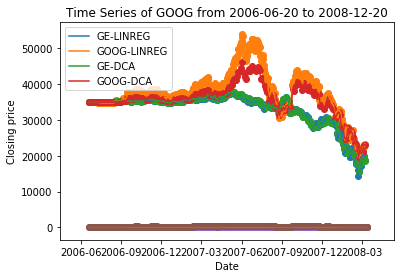

In [71]:
strategyList = ["LINREG", "DCA"]
daterange = (datetime.date(2006,6,20), datetime.date(2008,12,20))
stocks = ["GE", "GOOG"]
accountBalance = 35000
options = ['p=0','i=2','q=2','interval=3', 'train_size=1000']
results = simulation(strategyList, daterange, stocks, accountBalance,options)
visualize(results)

# Make Pretty and Analyze

In [66]:
def simplePlotInvestments(accts, principal):
    for strat, s in accounts.items():
        for stock, data in s.items():
            cash, account, timeseries = data
            plt.scatter(*zip(*timeseries))#, label=stock+"-"+strat)
            plt.plot(*zip(*timeseries), label=stock+"-"+strat)
            plt.title("Performance of investing " + str(accountBalance))# + " in " + stock + " using " + strat)
            plt.ylabel("Portfolio value")
            plt.xlabel("Time")
            plt.legend(loc='upper left')
            
def simplePlotStocks(stocks, timeframe):
    for stock, prices in stocks.items():
        xs = []
        ys = []
        for i in range(len(prices)):
            xs.append(timeframe[0]+datetime.timedelta(days=i))
            ys.append(prices[i])
        plt.scatter(xs, ys)
        plt.plot(xs, ys, label=stock)
        plt.title("Time Series of " + stock + " from " + str(timeframe[0]) + " to " + str(timeframe[1]))
        plt.xlabel("Date")
        plt.ylabel("Closing price")

#takes output of simulation function and plots / analyzes things
def visualize(results):
    accounts, stocks, timeframe, principal = results
    simplePlotInvestments(accounts, principal)
    simplePlotStocks(stocks, timeframe)